# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [ ]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [ ]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### FSC

In [ ]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

In [ ]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

In [ ]:
plt.plot(res, fsc)

In [ ]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [ ]:
fsc

In [ ]:
fsc[10]

In [ ]:
fsc[11]

In [ ]:
res_angs[10]

In [ ]:
res_angs[11]

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [57]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

NameError: name 'gradv_obj' is not defined

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [58]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

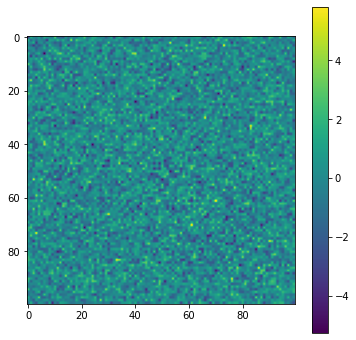

In [59]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [60]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [61]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [62]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [63]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

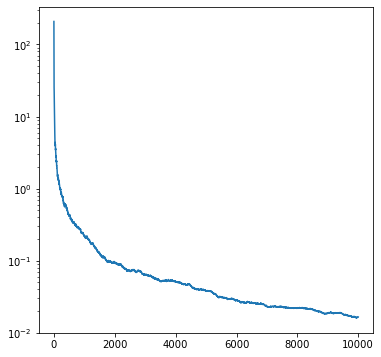

In [64]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [65]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [66]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [67]:
f(x0)

DeviceArray(0., dtype=float64)

In [68]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [69]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

0.5406475067138672
0.410994291305542


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


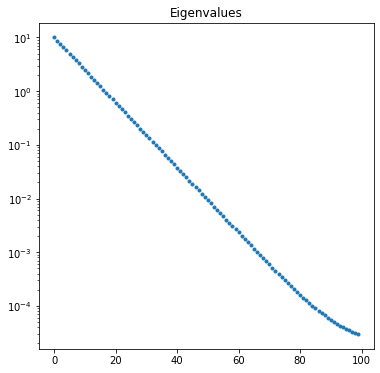

In [70]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [71]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 1109.756444401368
f(x_gt) = 114.06396219307904
gradF(x_gt) = [ 8.02989738 12.42697663  1.3507396  -5.95825358  2.40510104 -5.24308245
 -5.18600986 11.47943622 -3.39076778 -7.96825895 -2.58878468 -9.45578955
  5.69097812  5.20414337  4.13595372 -3.37971075 -2.1905374   5.3511184
 -9.34590165 -0.59185962 10.84388734  5.34625856  6.92061224 -3.04173597
 -5.83836935 -0.78862275  9.3041385   3.17481347  5.79494042 -3.85649957
  1.1579754  -0.16458123 -1.08134849  5.5992931   3.59208543 -2.04986531
 -7.14233958 -2.08403917  3.06291572 -1.48488714  5.73535915 -0.12522221
 -8.63296069 -6.00451057 -0.29034754 18.06797569 11.43344784 -3.16508
 -7.91866067  2.57810127  1.25187988  6.0052895  -2.02591605  6.82880742
 -6.13230944 -5.27791552  5.28265019  8.07157425 -5.77235536 -8.62415961
 -3.39962565  2.92420009  2.37403168 -3.77011478 -0.50855178  6.70828212
  7.15137048 13.11885955 -7.75961765  7.0798469   6.43547947 -6.52770851
 -6.14390755  0.80879995  9.27244169 -0.93906166  0.1

In [72]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [73]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 99.54599846120239
Iter 400: loss = 94.31829008177199
Iter 600: loss = 90.95030881933947
Iter 800: loss = 88.33664103232346
Iter 1000: loss = 86.21481472333979
Iter 1200: loss = 84.45907020273512
Iter 1400: loss = 82.98853070009763
Iter 1600: loss = 81.74564910075576
Iter 1800: loss = 80.68746715168986
Iter 2000: loss = 79.78089413037378
Iter 2200: loss = 78.9998472486105
Iter 2400: loss = 78.32341145894524
Iter 2600: loss = 77.73459947335115
Iter 2800: loss = 77.21948200996856
Iter 3000: loss = 76.76655574577019
Iter 3200: loss = 76.3662698091288
Iter 3400: loss = 76.01066193019142
Iter 3600: loss = 75.69307305756566
Iter 3800: loss = 75.4079198650297
Iter 4000: loss = 75.1505111155256
Iter 4200: loss = 74.916897997734
Iter 4400: loss = 74.70375125807433
Iter 4600: loss = 74.50825977252703
Iter 4800: loss = 74.32804646604772
Iter 5000: loss = 74.16109838990691
Iter 5200: loss = 74.00570843017809
Iter 5400: loss = 73.86042661970399
Iter 5600: loss = 73.72401940983396
It

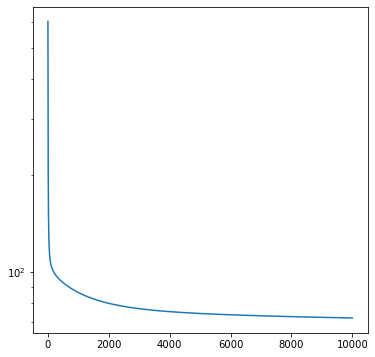

In [74]:
plt.semilogy(loss_gd)

In [75]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 62.896088396907274
Iter 2: loss = 62.89608839690733
Iter 3: loss = 62.896088396907324
Iter 4: loss = 62.89608839690735
Iter 5: loss = 62.896088396907324
Iter 6: loss = 62.8960883969073
Iter 7: loss = 62.8960883969073
Iter 8: loss = 62.89608839690737
Iter 9: loss = 62.896088396907324
Iter 10: loss = 62.89608839690731


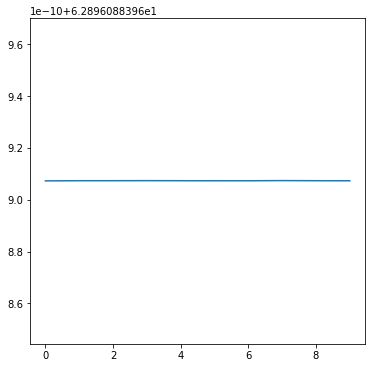

In [76]:
plt.plot(loss_n)

In [79]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 98.72069698090263
  cg iter 200 ||r|| = 6.7685281474011965e-06
  cg iter 400 ||r|| = 1.504907951480268e-10
  cg iter 600 ||r|| = 1.055844824814309e-11
  cg iter 800 ||r|| = 1.24678456775698e-12


In [80]:
F(x_cg)

DeviceArray(62.8960884, dtype=float64)

#### OASIS

In [81]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [82]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 200)


Epoch 200/10000


100%|██████████| 1/1 [00:00<00:00, 142.86it/s, loss=9.575e+01]

  Loss =  9.575e+01


Epoch 400/10000


100%|██████████| 1/1 [00:00<00:00, 84.19it/s, loss=9.020e+01]

  Loss =  9.020e+01


Epoch 600/10000


100%|██████████| 1/1 [00:00<00:00, 149.71it/s, loss=8.662e+01]

  Loss =  8.662e+01


Epoch 800/10000


100%|██████████| 1/1 [00:00<00:00, 133.83it/s, loss=8.396e+01]

  Loss =  8.396e+01


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 151.27it/s, loss=8.191e+01]

  Loss =  8.191e+01


Epoch 1200/10000


100%|██████████| 1/1 [00:00<00:00, 134.10it/s, loss=8.031e+01]

  Loss =  8.031e+01


Epoch 1400/10000


100%|██████████| 1/1 [00:00<00:00, 152.19it/s, loss=7.904e+01]

  Loss =  7.904e+01


Epoch 1600/10000


100%|██████████| 1/1 [00:00<00:00, 149.50it/s, loss=7.801e+01]

  Loss =  7.801e+01


Epoch 1800/10000


100%|██████████| 1/1 [00:00<00:00, 133.90it/s, loss=7.717e+01]

  Loss =  7.717e+01


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 136.34it/s, loss=7.648e+01]

  Loss =  7.648e+01


Epoch 2200/10000


100%|██████████| 1/1 [00:00<00:00, 141.55it/s, loss=7.590e+01]

  Loss =  7.590e+01


Epoch 2400/10000


100%|██████████| 1/1 [00:00<00:00, 159.80it/s, loss=7.541e+01]

  Loss =  7.541e+01


Epoch 2600/10000


100%|██████████| 1/1 [00:00<00:00, 232.72it/s, loss=7.499e+01]

  Loss =  7.499e+01


Epoch 2800/10000


100%|██████████| 1/1 [00:00<00:00, 232.37it/s, loss=7.462e+01]

  Loss =  7.462e+01


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 196.15it/s, loss=7.430e+01]

  Loss =  7.430e+01


Epoch 3200/10000


100%|██████████| 1/1 [00:00<00:00, 175.89it/s, loss=7.402e+01]

  Loss =  7.402e+01


Epoch 3400/10000


100%|██████████| 1/1 [00:00<00:00, 173.32it/s, loss=7.377e+01]

  Loss =  7.377e+01


Epoch 3600/10000


100%|██████████| 1/1 [00:00<00:00, 143.14it/s, loss=7.354e+01]

  Loss =  7.354e+01


Epoch 3800/10000


100%|██████████| 1/1 [00:00<00:00, 150.66it/s, loss=7.333e+01]

  Loss =  7.333e+01


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 223.70it/s, loss=7.314e+01]

  Loss =  7.314e+01


Epoch 4200/10000


100%|██████████| 1/1 [00:00<00:00, 147.29it/s, loss=7.296e+01]

  Loss =  7.296e+01


Epoch 4400/10000


100%|██████████| 1/1 [00:00<00:00, 148.03it/s, loss=7.280e+01]

  Loss =  7.280e+01


Epoch 4600/10000


100%|██████████| 1/1 [00:00<00:00, 158.31it/s, loss=7.264e+01]

  Loss =  7.264e+01


Epoch 4800/10000


100%|██████████| 1/1 [00:00<00:00, 208.34it/s, loss=7.250e+01]

  Loss =  7.250e+01


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 199.45it/s, loss=7.236e+01]

  Loss =  7.236e+01


Epoch 5200/10000


100%|██████████| 1/1 [00:00<00:00, 220.07it/s, loss=7.224e+01]

  Loss =  7.224e+01


Epoch 5400/10000


100%|██████████| 1/1 [00:00<00:00, 139.00it/s, loss=7.211e+01]

  Loss =  7.211e+01


Epoch 5600/10000


100%|██████████| 1/1 [00:00<00:00, 198.00it/s, loss=7.200e+01]

  Loss =  7.200e+01


Epoch 5800/10000


100%|██████████| 1/1 [00:00<00:00, 131.26it/s, loss=7.189e+01]

  Loss =  7.189e+01


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 159.24it/s, loss=7.178e+01]

  Loss =  7.178e+01


Epoch 6200/10000


100%|██████████| 1/1 [00:00<00:00, 152.95it/s, loss=7.168e+01]

  Loss =  7.168e+01


Epoch 6400/10000


100%|██████████| 1/1 [00:00<00:00, 125.75it/s, loss=7.158e+01]

  Loss =  7.158e+01


Epoch 6600/10000


100%|██████████| 1/1 [00:00<00:00, 190.26it/s, loss=7.149e+01]

  Loss =  7.149e+01


Epoch 6800/10000


100%|██████████| 1/1 [00:00<00:00, 153.29it/s, loss=7.140e+01]

  Loss =  7.140e+01


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 149.69it/s, loss=7.132e+01]

  Loss =  7.132e+01


Epoch 7200/10000


100%|██████████| 1/1 [00:00<00:00, 227.04it/s, loss=7.123e+01]

  Loss =  7.123e+01


Epoch 7400/10000


100%|██████████| 1/1 [00:00<00:00, 142.14it/s, loss=7.115e+01]

  Loss =  7.115e+01


Epoch 7600/10000


100%|██████████| 1/1 [00:00<00:00, 156.00it/s, loss=7.107e+01]

  Loss =  7.107e+01


Epoch 7800/10000


100%|██████████| 1/1 [00:00<00:00, 149.49it/s, loss=7.100e+01]

  Loss =  7.100e+01


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 137.99it/s, loss=7.093e+01]

  Loss =  7.093e+01


Epoch 8200/10000


100%|██████████| 1/1 [00:00<00:00, 133.64it/s, loss=7.086e+01]

  Loss =  7.086e+01


Epoch 8400/10000


100%|██████████| 1/1 [00:00<00:00, 201.67it/s, loss=7.079e+01]

  Loss =  7.079e+01


Epoch 8600/10000


100%|██████████| 1/1 [00:00<00:00, 175.11it/s, loss=7.072e+01]

  Loss =  7.072e+01


Epoch 8800/10000


100%|██████████| 1/1 [00:00<00:00, 140.37it/s, loss=7.066e+01]

  Loss =  7.066e+01


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 181.29it/s, loss=7.059e+01]

  Loss =  7.059e+01


Epoch 9200/10000


100%|██████████| 1/1 [00:00<00:00, 172.98it/s, loss=7.053e+01]

  Loss =  7.053e+01


Epoch 9400/10000


100%|██████████| 1/1 [00:00<00:00, 142.66it/s, loss=7.047e+01]

  Loss =  7.047e+01


Epoch 9600/10000


100%|██████████| 1/1 [00:00<00:00, 139.50it/s, loss=7.042e+01]

  Loss =  7.042e+01


Epoch 9800/10000


100%|██████████| 1/1 [00:00<00:00, 123.73it/s, loss=7.036e+01]

  Loss =  7.036e+01


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 146.84it/s, loss=7.030e+01]

  Loss =  7.030e+01


In [83]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 200)


Epoch 200/10000


100%|██████████| 1/1 [00:00<00:00, 109.56it/s, loss=7.435e+01]

  Loss =  7.435e+01


Epoch 400/10000


100%|██████████| 1/1 [00:00<00:00, 141.69it/s, loss=7.185e+01]

  Loss =  7.185e+01


Epoch 600/10000


100%|██████████| 1/1 [00:00<00:00, 148.37it/s, loss=7.065e+01]

  Loss =  7.065e+01


Epoch 800/10000


100%|██████████| 1/1 [00:00<00:00, 119.29it/s, loss=6.987e+01]

  Loss =  6.987e+01


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 128.51it/s, loss=6.929e+01]

  Loss =  6.929e+01


Epoch 1200/10000


100%|██████████| 1/1 [00:00<00:00, 134.94it/s, loss=6.885e+01]

  Loss =  6.885e+01


Epoch 1400/10000


100%|██████████| 1/1 [00:00<00:00, 126.87it/s, loss=6.846e+01]

  Loss =  6.846e+01


Epoch 1600/10000


100%|██████████| 1/1 [00:00<00:00, 111.37it/s, loss=6.814e+01]

  Loss =  6.814e+01


Epoch 1800/10000


100%|██████████| 1/1 [00:00<00:00, 154.24it/s, loss=6.784e+01]

  Loss =  6.784e+01


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 79.64it/s, loss=6.759e+01]

  Loss =  6.759e+01


Epoch 2200/10000


100%|██████████| 1/1 [00:00<00:00, 163.62it/s, loss=6.736e+01]

  Loss =  6.736e+01


Epoch 2400/10000


100%|██████████| 1/1 [00:00<00:00, 191.15it/s, loss=6.714e+01]

  Loss =  6.714e+01


Epoch 2600/10000


100%|██████████| 1/1 [00:00<00:00, 117.46it/s, loss=6.694e+01]

  Loss =  6.694e+01


Epoch 2800/10000


100%|██████████| 1/1 [00:00<00:00, 87.21it/s, loss=6.676e+01]

  Loss =  6.676e+01


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 134.53it/s, loss=6.658e+01]

  Loss =  6.658e+01


Epoch 3200/10000


100%|██████████| 1/1 [00:00<00:00, 114.69it/s, loss=6.643e+01]

  Loss =  6.643e+01


Epoch 3400/10000


100%|██████████| 1/1 [00:00<00:00, 114.01it/s, loss=6.628e+01]

  Loss =  6.628e+01


Epoch 3600/10000


100%|██████████| 1/1 [00:00<00:00, 124.67it/s, loss=6.615e+01]

  Loss =  6.615e+01


Epoch 3800/10000


100%|██████████| 1/1 [00:00<00:00, 120.33it/s, loss=6.602e+01]

  Loss =  6.602e+01


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 112.20it/s, loss=6.590e+01]

  Loss =  6.590e+01


Epoch 4200/10000


100%|██████████| 1/1 [00:00<00:00, 149.68it/s, loss=6.577e+01]

  Loss =  6.577e+01


Epoch 4400/10000


100%|██████████| 1/1 [00:00<00:00, 132.60it/s, loss=6.567e+01]

  Loss =  6.567e+01


Epoch 4600/10000


100%|██████████| 1/1 [00:00<00:00, 185.11it/s, loss=6.557e+01]

  Loss =  6.557e+01


Epoch 4800/10000


100%|██████████| 1/1 [00:00<00:00, 122.74it/s, loss=6.547e+01]

  Loss =  6.547e+01


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 102.26it/s, loss=6.538e+01]

  Loss =  6.538e+01


Epoch 5200/10000


100%|██████████| 1/1 [00:00<00:00, 64.37it/s, loss=6.529e+01]

  Loss =  6.529e+01


Epoch 5400/10000


100%|██████████| 1/1 [00:00<00:00, 91.10it/s, loss=6.521e+01]

  Loss =  6.521e+01


Epoch 5600/10000


100%|██████████| 1/1 [00:00<00:00, 139.49it/s, loss=6.514e+01]

  Loss =  6.514e+01


Epoch 5800/10000


100%|██████████| 1/1 [00:00<00:00, 116.00it/s, loss=6.507e+01]

  Loss =  6.507e+01


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 145.02it/s, loss=6.500e+01]

  Loss =  6.500e+01


Epoch 6200/10000


100%|██████████| 1/1 [00:00<00:00, 103.27it/s, loss=6.493e+01]

  Loss =  6.493e+01


Epoch 6400/10000


100%|██████████| 1/1 [00:00<00:00, 118.20it/s, loss=6.487e+01]

  Loss =  6.487e+01


Epoch 6600/10000


100%|██████████| 1/1 [00:00<00:00, 80.08it/s, loss=6.481e+01]

  Loss =  6.481e+01


Epoch 6800/10000


100%|██████████| 1/1 [00:00<00:00, 141.81it/s, loss=6.475e+01]

  Loss =  6.475e+01


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 185.36it/s, loss=6.469e+01]

  Loss =  6.469e+01


Epoch 7200/10000


100%|██████████| 1/1 [00:00<00:00, 140.84it/s, loss=6.464e+01]

  Loss =  6.464e+01


Epoch 7400/10000


100%|██████████| 1/1 [00:00<00:00, 122.04it/s, loss=6.459e+01]

  Loss =  6.459e+01


Epoch 7600/10000


100%|██████████| 1/1 [00:00<00:00, 156.10it/s, loss=6.454e+01]

  Loss =  6.454e+01


Epoch 7800/10000


100%|██████████| 1/1 [00:00<00:00, 90.66it/s, loss=6.449e+01]

  Loss =  6.449e+01


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 143.99it/s, loss=6.445e+01]

  Loss =  6.445e+01


Epoch 8200/10000


100%|██████████| 1/1 [00:00<00:00, 125.14it/s, loss=6.441e+01]

  Loss =  6.441e+01


Epoch 8400/10000


100%|██████████| 1/1 [00:00<00:00, 202.72it/s, loss=6.437e+01]

  Loss =  6.437e+01


Epoch 8600/10000


100%|██████████| 1/1 [00:00<00:00, 115.84it/s, loss=6.433e+01]

  Loss =  6.433e+01


Epoch 8800/10000


100%|██████████| 1/1 [00:00<00:00, 114.49it/s, loss=6.429e+01]

  Loss =  6.429e+01


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 92.60it/s, loss=6.425e+01]

  Loss =  6.425e+01


Epoch 9200/10000


100%|██████████| 1/1 [00:00<00:00, 147.18it/s, loss=6.422e+01]

  Loss =  6.422e+01


Epoch 9400/10000


100%|██████████| 1/1 [00:00<00:00, 120.72it/s, loss=6.418e+01]

  Loss =  6.418e+01


Epoch 9600/10000


100%|██████████| 1/1 [00:00<00:00, 115.00it/s, loss=6.415e+01]

  Loss =  6.415e+01


Epoch 9800/10000


100%|██████████| 1/1 [00:00<00:00, 129.47it/s, loss=6.412e+01]

  Loss =  6.412e+01


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 119.88it/s, loss=6.409e+01]

  Loss =  6.409e+01


12.477505063771066
12.477505063521798
3.982755915053665
6.229225755506574
12.481451894198093


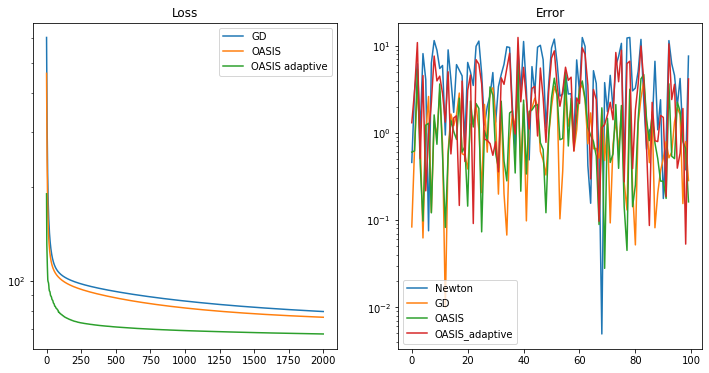

In [84]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [85]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [101]:
sig_noise = 10
lam = 0.1

In [102]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [103]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.52e+02


In [104]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [105]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

55.49298309401981
50.20230162892993
(100,)
(100,)
(100,)
(100,)


In [106]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [107]:
Fidx(x_gt, jnp.arange(N))

DeviceArray(50.20230163, dtype=float64)

In [108]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:04<00:00, 12.40it/s, loss=3.188e+02]


  Loss =  1.639e+05
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 142.63it/s, loss=4.927e+01]


  Loss =  7.656e+01
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 141.71it/s, loss=4.877e+01]


  Loss =  4.986e+01
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 147.28it/s, loss=5.086e+01]


  Loss =  4.988e+01
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 141.71it/s, loss=4.839e+01]


  Loss =  4.985e+01
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 141.37it/s, loss=5.055e+01]


  Loss =  4.986e+01
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 143.73it/s, loss=5.135e+01]


  Loss =  4.986e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 140.07it/s, loss=4.797e+01]


  Loss =  4.985e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 145.23it/s, loss=5.094e+01]


  Loss =  4.985e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 148.70it/s, loss=5.135e+01]


  Loss =  4.984e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 142.46it/s, loss=4.970e+01]


  Loss =  4.985e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 145.36it/s, loss=5.055e+01]


  Loss =  4.986e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 147.87it/s, loss=5.023e+01]


  Loss =  4.986e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 141.43it/s, loss=5.159e+01]


  Loss =  4.985e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 146.33it/s, loss=4.987e+01]


  Loss =  4.984e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 145.43it/s, loss=4.741e+01]


  Loss =  4.985e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 145.72it/s, loss=5.053e+01]


  Loss =  4.986e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 152.55it/s, loss=5.230e+01]


  Loss =  4.986e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 150.12it/s, loss=5.326e+01]


  Loss =  4.985e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 134.45it/s, loss=4.954e+01]


  Loss =  4.985e+01


In [109]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:00<00:00, 119.74it/s, loss=6.446e+01]


  Loss =  1.403e+05
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 123.19it/s, loss=4.749e+01]


  Loss =  5.070e+01
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 119.09it/s, loss=5.086e+01]


  Loss =  4.984e+01
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 119.00it/s, loss=4.612e+01]


  Loss =  4.984e+01
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 115.25it/s, loss=4.912e+01]


  Loss =  4.985e+01
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 120.49it/s, loss=4.741e+01]


  Loss =  4.981e+01
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 113.33it/s, loss=4.955e+01]


  Loss =  4.978e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 121.68it/s, loss=4.917e+01]


  Loss =  4.980e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 119.19it/s, loss=4.693e+01]


  Loss =  4.983e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 123.22it/s, loss=4.791e+01]


  Loss =  4.983e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 119.99it/s, loss=4.856e+01]


  Loss =  4.981e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 117.03it/s, loss=4.876e+01]


  Loss =  4.984e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 116.97it/s, loss=5.195e+01]


  Loss =  4.984e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 115.57it/s, loss=4.874e+01]


  Loss =  4.983e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 125.59it/s, loss=4.937e+01]


  Loss =  4.981e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 113.24it/s, loss=4.995e+01]


  Loss =  4.986e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 116.83it/s, loss=4.918e+01]


  Loss =  4.988e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 118.76it/s, loss=4.760e+01]


  Loss =  4.984e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 128.01it/s, loss=5.010e+01]


  Loss =  4.977e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 118.95it/s, loss=4.839e+01]


  Loss =  4.988e+01


In [110]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

Epoch 1/10


100%|██████████| 1/1 [00:01<00:00,  1.29s/it, loss=1.630e+06]


  Loss =  1.630e+06
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00, 71.04it/s, loss=1.327e+06]


  Loss =  1.327e+06
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00, 85.01it/s, loss=1.086e+06]


  Loss =  1.086e+06
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00, 87.09it/s, loss=8.922e+05]


  Loss =  8.922e+05
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00, 89.33it/s, loss=7.353e+05]


  Loss =  7.353e+05
Epoch 6/10


100%|██████████| 1/1 [00:00<00:00, 75.94it/s, loss=6.076e+05]


  Loss =  6.076e+05
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00, 81.34it/s, loss=5.032e+05]


  Loss =  5.032e+05
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00, 100.09it/s, loss=4.175e+05]


  Loss =  4.175e+05
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00, 86.87it/s, loss=3.470e+05]


  Loss =  3.470e+05
Epoch 10/10


100%|██████████| 1/1 [00:00<00:00, 86.40it/s, loss=2.887e+05]

  Loss =  2.887e+05


In [111]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


Epoch 1/10


100%|██████████| 1/1 [00:00<00:00, 68.69it/s, loss=1.750e+06]


  Loss =  1.750e+06
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00, 64.80it/s, loss=1.461e+06]


  Loss =  1.461e+06
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00, 56.39it/s, loss=1.113e+06]


  Loss =  1.113e+06
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00, 72.40it/s, loss=7.208e+05]


  Loss =  7.208e+05
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00, 61.45it/s, loss=3.507e+05]


  Loss =  3.507e+05
Epoch 6/10


100%|██████████| 1/1 [00:00<00:00, 70.37it/s, loss=1.141e+05]


  Loss =  1.141e+05
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00, 71.67it/s, loss=3.971e+04]


  Loss =  3.971e+04
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00, 59.40it/s, loss=3.349e+04]


  Loss =  3.349e+04
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00, 77.15it/s, loss=1.996e+04]

  Loss =  1.996e+04
Epoch 10/10



100%|██████████| 1/1 [00:00<00:00, 73.54it/s, loss=1.719e+04]

  Loss =  1.719e+04


In [114]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 477.26it/s, grad=2.888e+04, loss=1.525e+05]


  |Grad| = 7.729e+04
  Loss = 7.702e+05
Epoch 2/20 

100%|██████████| 50/50 [00:00<00:00, 495.74it/s, grad=9.661e+03, loss=1.436e+04]


  |Grad| = 1.917e+04
  Loss = 5.234e+04
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 607.00it/s, grad=3.096e+03, loss=1.163e+03]


  |Grad| = 5.510e+03
  Loss = 4.406e+03
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 530.13it/s, grad=9.070e+02, loss=1.407e+02]


  |Grad| = 1.655e+03
  Loss = 4.576e+02
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 522.27it/s, grad=2.939e+02, loss=6.418e+01]


  |Grad| = 5.589e+02
  Loss = 9.163e+01
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 460.01it/s, grad=1.374e+02, loss=5.420e+01]


  |Grad| = 2.136e+02
  Loss = 5.457e+01
Epoch 7/20 

100%|██████████| 50/50 [00:00<00:00, 445.65it/s, grad=1.024e+02, loss=5.195e+01]


  |Grad| = 1.183e+02
  Loss = 5.059e+01
Epoch 8/20 

100%|██████████| 50/50 [00:00<00:00, 491.76it/s, grad=9.801e+01, loss=5.066e+01]


  |Grad| = 1.041e+02
  Loss = 5.013e+01
Epoch 9/20 

100%|██████████| 50/50 [00:00<00:00, 537.85it/s, grad=1.043e+02, loss=5.151e+01]


  |Grad| = 1.050e+02
  Loss = 5.008e+01
Epoch 10/20 

100%|██████████| 50/50 [00:00<00:00, 513.90it/s, grad=9.266e+01, loss=5.124e+01]


  |Grad| = 1.043e+02
  Loss = 5.007e+01
Epoch 11/20 

100%|██████████| 50/50 [00:00<00:00, 474.38it/s, grad=9.566e+01, loss=5.085e+01]


  |Grad| = 1.068e+02
  Loss = 5.006e+01
Epoch 12/20 

100%|██████████| 50/50 [00:00<00:00, 510.22it/s, grad=1.010e+02, loss=4.816e+01]


  |Grad| = 1.069e+02
  Loss = 5.007e+01
Epoch 13/20 

100%|██████████| 50/50 [00:00<00:00, 471.85it/s, grad=7.677e+01, loss=4.628e+01]


  |Grad| = 1.032e+02
  Loss = 5.007e+01
Epoch 14/20 

100%|██████████| 50/50 [00:00<00:00, 504.28it/s, grad=9.795e+01, loss=5.283e+01]


  |Grad| = 1.034e+02
  Loss = 5.007e+01
Epoch 15/20 

100%|██████████| 50/50 [00:00<00:00, 482.11it/s, grad=1.290e+02, loss=4.890e+01]


  |Grad| = 1.026e+02
  Loss = 5.007e+01
Epoch 16/20 

100%|██████████| 50/50 [00:00<00:00, 553.99it/s, grad=1.361e+02, loss=4.965e+01]


  |Grad| = 1.034e+02
  Loss = 5.007e+01
Epoch 17/20 

100%|██████████| 50/50 [00:00<00:00, 556.69it/s, grad=8.538e+01, loss=4.836e+01]


  |Grad| = 1.071e+02
  Loss = 5.007e+01
Epoch 18/20 

100%|██████████| 50/50 [00:00<00:00, 496.34it/s, grad=1.054e+02, loss=4.893e+01]


  |Grad| = 1.038e+02
  Loss = 5.007e+01
Epoch 19/20 

100%|██████████| 50/50 [00:00<00:00, 472.27it/s, grad=1.084e+02, loss=4.974e+01]


  |Grad| = 1.080e+02
  Loss = 5.007e+01
Epoch 20/20 

100%|██████████| 50/50 [00:00<00:00, 520.72it/s, grad=9.755e+01, loss=4.960e+01]


  |Grad| = 1.050e+02
  Loss = 5.007e+01


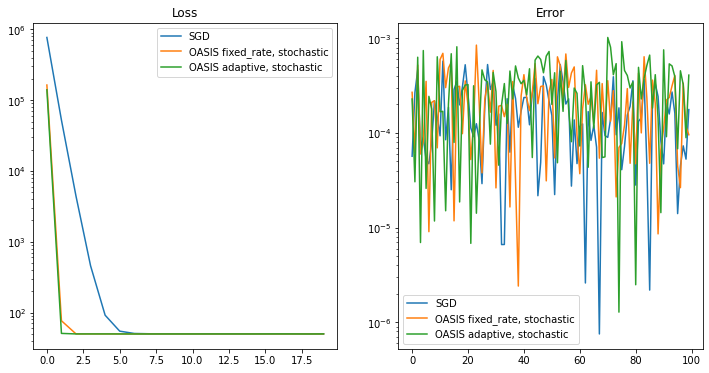

In [115]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* Make the Hessian illconditioned rather than the operator(s) $A$ (how? maybe not worth it)
* Implement some kind of warm up /estimation of $D_0$
* Run on CryoEM data